In [16]:
# Import necessary libraries for preprocessing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

pd.set_option('future.no_silent_downcasting', True)

# Load the dataset
Ames = pd.read_csv('Ames.csv')

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

# Exclude 'PID' and 'SalePrice' from features and specifically handle the 'Electrical' column
numeric_features = Ames.select_dtypes(include=['int64', 'float64']).drop(columns=['PID', 'SalePrice']).columns
categorical_features = Ames.select_dtypes(include=['object']).columns.difference(['Electrical'])
electrical_feature = ['Electrical']

# Manually specify the categories for ordinal encoding according to the data dictionary
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']  # Fence quality
}

# Extract list of ALL ordinal features from dictionary
ordinal_features = list(ordinal_order.keys())

# List of ordinal features except Electrical
ordinal_except_electrical = [feature for feature in ordinal_features if feature != 'Electrical']

# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")



# Pipeline for 'Electrical': Fill missing value with mode then apply ordinal encoding
electrical_transformer = Pipeline(steps=[
    ('impute_electrical', SimpleImputer(strategy='most_frequent')),
    ('ordinal_electrical', OrdinalEncoder(categories=[ordinal_order['Electrical']]))
])

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean'))
])

# Pipeline for ordinal features: Fill missing values with 'None' then apply ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('fill_none', FunctionTransformer(fill_none, validate=False)),
    ('ordinal', OrdinalEncoder(categories=[ordinal_order[feature] for feature in ordinal_features if feature in ordinal_except_electrical]))
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]
categorical_transformer = Pipeline(steps=[
    ('fill_none', FunctionTransformer(fill_none, validate=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # or sparse=False on older versions
])

# Combined preprocessor for numeric, ordinal, nominal, and specific electrical data
preprocessor = ColumnTransformer(
    transformers=[
        ('electrical', electrical_transformer, ['Electrical']),
        ('num', numeric_transformer, numeric_features),
        ('ordinal', ordinal_transformer, ordinal_except_electrical),
        ('nominal', categorical_transformer, nominal_features)
])

# Apply the preprocessing pipeline to Ames
transformed_data = preprocessor.fit_transform(Ames)

# Generate column names for the one-hot encoded features
onehot = preprocessor.named_transformers_['nominal'].named_steps['onehot']
onehot_features = onehot.get_feature_names_out(nominal_features)

# Combine all feature names
all_feature_names = ['Electrical'] + list(numeric_features) + list(ordinal_except_electrical) + list(onehot_features)

# Convert the transformed array to a DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

In [17]:
# # Optional command for expanded view
# pd.set_option('display.max_columns', None)

# View the transformation
print(transformed_df)

      Electrical  Unnamed: 0  GrLivArea  LotFrontage  LotArea  OverallQual  \
0            4.0         1.0      856.0    68.516053   7890.0          6.0   
1            4.0         2.0     1049.0    42.000000   4235.0          5.0   
2            4.0         3.0     1001.0    60.000000   6060.0          5.0   
3            4.0         4.0     1039.0    80.000000   8146.0          4.0   
4            4.0         5.0     1665.0    70.000000   8400.0          8.0   
...          ...         ...        ...          ...      ...          ...   
2575         2.0       759.0      952.0    68.516053   8854.0          6.0   
2576         3.0       760.0     1733.0    68.516053  13680.0          3.0   
2577         3.0       761.0     2002.0    82.000000   6270.0          5.0   
2578         4.0       762.0     1842.0    68.516053   8826.0          7.0   
2579         4.0       763.0     1911.0    80.000000   9554.0          8.0   

      OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ...  Sa

In [18]:
#Quick way to cross-check number of columns after preprocessing
print(len(numeric_features) + len(ordinal_features) + Ames[nominal_features].fillna("None").nunique().sum())

257


In [70]:
target = Ames['SalePrice']

features = transformed_df

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

In [65]:
rf = RandomForestRegressor()

In [66]:
cv = StratifiedKFold(5)
grid = {'n_estimators':range(30,110,30), 'max_depth':range(3,20,2)}
gsCV = GridSearchCV(rf, grid, cv=cv, return_train_score=True, n_jobs=4)

In [71]:
results = gsCV.fit(features, target)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


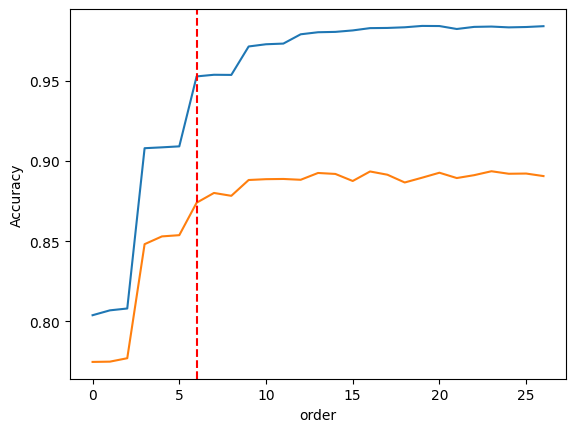

In [74]:
ans=pd.DataFrame(results.cv_results_)
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=6,linestyle='--', color='r')
plt.show()

In [75]:
ans['params'][6]

{'max_depth': 7, 'n_estimators': 30}

In [76]:
rf.set_params(max_depth=7, n_estimators=30)
rf.fit(features, target)

RandomForestRegressor(max_depth=7, n_estimators=30)

In [77]:
model_importance = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=False)

model_importance.head(10)

OverallQual    0.573478
GrLivArea      0.154570
TotalBsmtSF    0.051834
1stFlrSF       0.047326
BsmtFinSF1     0.029455
GarageArea     0.016793
BsmtQual       0.011576
LotArea        0.008171
YearBuilt      0.008106
2ndFlrSF       0.005438
dtype: float64

Exception ignored in: <function ResourceTracker.__del__ at 0x102619bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105ca5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103665bc0>
Traceback (most recent call last

In [20]:
# Build on previous blocks of code
# Import additional necessary libraries for modeling and evaluation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Define the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Evaluate the model using cross-validation
scores = cross_val_score(model_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'])

# Output the result
print("Decision Tree Regressor Mean CV R²:", round(scores.mean(),4))

Decision Tree Regressor Mean CV R²: 0.7562


In [22]:
# Import Bagging Regressor and build on previous blocks of code
# Compare how performance is affected by Bagging (i.e. increasing number of trees)

from sklearn.ensemble import BaggingRegressor

models = {
    'Decision Tree (1 Tree)': DecisionTreeRegressor(random_state=42),
    'Bagging Regressor (10 Trees)': BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                          n_estimators=10, random_state=42)
}

results = {}
for name, model in models.items():
    # Define the full model pipeline for each model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Perform cross-validation
    scores = cross_val_score(model_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'])

    # Store and print the mean of the scores
    results[name] = round(scores.mean(), 4)

# Output the cross-validation scores
print("Cross-validation scores:", results)

Cross-validation scores: {'Decision Tree (1 Tree)': np.float64(0.7562), 'Bagging Regressor (10 Trees)': np.float64(0.8771)}


In [24]:
# Build on previous blocks of code
# Compare how performance is affected by Bagging in increments of 10 trees

# Number of trees to test
n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Define the model pipelines with various regressors
models = {
    'Decision Tree (1 Tree)': DecisionTreeRegressor(random_state=42)
}

# Adding Bagging models for each tree count
for n in n_trees:
    models[f'Bagging Regressor {n} Trees'] = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=n,
        random_state=42
    )

results = {}
for name, model in models.items():
    # Define the full model pipeline for each model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Perform cross-validation
    scores = cross_val_score(model_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'])

    # Store and print the mean of the scores
    results[name] = round(scores.mean(), 4)

# Output the cross-validation scores
print("Cross-validation scores:")
for name, score in results.items():
    print(f"{name}: {score}")

Cross-validation scores:
Decision Tree (1 Tree): 0.7562
Bagging Regressor 10 Trees: 0.8771
Bagging Regressor 20 Trees: 0.886
Bagging Regressor 30 Trees: 0.8894
Bagging Regressor 40 Trees: 0.8903
Bagging Regressor 50 Trees: 0.8914
Bagging Regressor 60 Trees: 0.8914
Bagging Regressor 70 Trees: 0.8924
Bagging Regressor 80 Trees: 0.8928
Bagging Regressor 90 Trees: 0.8933
Bagging Regressor 100 Trees: 0.893


In [26]:
# Build on previous blocks of code
# Evaluate performance of Random Forest against Bagging Regressor

from sklearn.ensemble import RandomForestRegressor

# Number of trees to test
n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Define the model pipelines with various regressors
models = {
    'Decision Tree (1 Tree)': DecisionTreeRegressor(random_state=42),
}

# Adding Bagging and Random Forest models for each tree count
for n in n_trees:
    models[f'Bagging Regressor {n} Trees'] = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        n_estimators=n,
        random_state=42
    )
    models[f'Random Forest {n} Trees'] = RandomForestRegressor(
        n_estimators=n,
        random_state=42
    )

results = {}
for name, model in models.items():
    # Define the full model pipeline for each model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Perform cross-validation
    scores = cross_val_score(model_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'])

    # Store and print the mean of the scores
    results[name] = round(scores.mean(), 4)

# Output the cross-validation scores
print("Cross-validation scores:")
for name, score in results.items():
    print(f"{name}: {score}")

Cross-validation scores:
Decision Tree (1 Tree): 0.7562
Bagging Regressor 10 Trees: 0.8771
Random Forest 10 Trees: 0.8775
Bagging Regressor 20 Trees: 0.886
Random Forest 20 Trees: 0.8864
Bagging Regressor 30 Trees: 0.8894
Random Forest 30 Trees: 0.8887
Bagging Regressor 40 Trees: 0.8903
Random Forest 40 Trees: 0.8906
Bagging Regressor 50 Trees: 0.8914
Random Forest 50 Trees: 0.8916
Bagging Regressor 60 Trees: 0.8914
Random Forest 60 Trees: 0.8913
Bagging Regressor 70 Trees: 0.8924
Random Forest 70 Trees: 0.8915
Bagging Regressor 80 Trees: 0.8928
Random Forest 80 Trees: 0.8924
Bagging Regressor 90 Trees: 0.8933
Random Forest 90 Trees: 0.8929
Bagging Regressor 100 Trees: 0.893
Random Forest 100 Trees: 0.8932


In [29]:
br = models['Bagging Regressor 20 Trees']

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [38]:
cv = StratifiedKFold(5)
grid = {'n_estimators':range(30,110,30)}
gsCV = GridSearchCV(br, grid, cv=cv, return_train_score=True, n_jobs=4)

In [39]:
results = gsCV.fit(Ames.drop(columns='SalePrice'), Ames['SalePrice'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py", line 389, in fit
    return self._fit(X, y, max_samples=self.max_samples, **fit_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py", line 532, in _fit
    all_results = Parallel(
        n_jobs=n_jobs, verbose=self.verbose, **self._parallel_args()
    )(
        delayed(_parallel_build_estimators)(
    ...<10 lines>...
        for i in range(n_jobs)
    )
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ~~~~^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/parallel.py", line 139, in __call__
    return self.function(*args, **kwargs)
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py", line 189, in _parallel_build_estimators
    estimator_fit(X_, y, **fit_params_)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/tree/_classes.py", line 1404, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'RL'


Exception ignored in: <function ResourceTracker.__del__ at 0x109765bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104b21bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105465bc0>
Traceback (most recent call last